In [43]:
import math
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns

import bokeh.io
import bokeh.plotting
import bokeh.models

bokeh.io.output_notebook()

Loading BokehJS ...

## Load in the datasets

In [65]:
# Load in the hygiene gene data
hyg_df = pd.read_csv("../data/hygiene_genes.csv", header=0)
hyg_df.drop(columns=['Unnamed: 0'], inplace=True)

# add a log(fc) column
hyg_df['log(FC)'] = np.log(hyg_df['FC'].values + 0.0000001)

hyg_df.head()

Gene Hygiene         Chromosome  Hygienic FPKM  Non-hygienic FPKM  \
0           Cac       H               Chr3        7.79884           5.121430   
1          CPR5       H              Chr16       72.64000          43.537500   
2       CYP6AS1       H              Chr13        2.04404           0.281032   
3         Gat-a       H               Chr1       11.79300           6.293340   
4  LOC100576698       H  Unplaced scaffold       21.77570          11.073200   

    q_value                          Gene product        FC   log(FC)  
0  0.043519                             cacophony  1.522786  0.420541  
1  0.043519                   cuticular protein 5  1.668447  0.511893  
2  0.007550                  cytochrome P450 6AS1  7.273335  1.984215  
3  0.007550  GABA neurotransmitter transporter-1A  1.873886  0.628014  
4  0.007550             hypothetical LOC100576698  1.966523  0.676267

In [2]:
# Load in the NCBI bee gene reference data
ref_genes = pd.read_csv(
    "../data/amel_genes.tsv", 
    sep="\t", 
    header=0, 
)

ref_genes.head()

NCBI GeneID    Symbol                   Description  Taxonomic Name  \
0       406130      Melt                      melittin  Apis mellifera   
1       406088        Vg                  vitellogenin  Apis mellifera   
2       406141      Pla2              phospholipase A2  Apis mellifera   
3       406074       Csd  complementary sex determiner  Apis mellifera   
4       544668  28S rRNA             28S ribosomal RNA  Apis mellifera   

        Gene Type  Gene Group Identifier Gene Group Method  
0  PROTEIN_CODING                    NaN               NaN  
1  PROTEIN_CODING                    NaN               NaN  
2  PROTEIN_CODING                    NaN               NaN  
3  PROTEIN_CODING                    NaN               NaN  
4            rRNA                    NaN               NaN

In [3]:
# Load in the original file into Pandas DF
raw_counts = pd.read_csv(
    "../data/GSE81664_Raw_counts_RNA-Seq_Beedoc.txt", 
    sep="\t", 
    header=0, 
    names=["Gene", "A1", "A2", "A3", "B1", "B2", "B3", "C1", "C2", "C3", "D1", "D2"]
)

# transpose the DF s.t. each bee is a row
raw_counts = raw_counts.transpose()

# make the "Gene" row the new columns
raw_counts.columns = raw_counts.iloc[0]
raw_counts.drop(inplace=True, index=["Gene"])

# add experimental condition for each bee
condtn = ["control", "control", "control", "Nosema", "Nosema", "Nosema", "BQCV", "BQCV", "BQCV", "both", "both"]
raw_counts["Experimental condition"] = condtn

# rearrange columns
cols = list(raw_counts.columns.values)
new_cols = cols[:-1]
new_cols.insert(0, cols[-1])
raw_counts = raw_counts[new_cols]

raw_counts

Gene Experimental condition  409663  409203  725343  409404  551807  726280  \
A1                  control       0    8763    4198    2332   14731   10106   
A2                  control       0    3511    2010    1075    6212    3300   
A3                  control       0    9134    4166    2507   14787    8264   
B1                   Nosema       0    7409    3488    2073   12577    8978   
B2                   Nosema       0    8024    3801    2281   14005    9299   
B3                   Nosema       0   10473    4377    2748   15764    9627   
C1                     BQCV       0    4547    2007    1292    7673    5258   
C2                     BQCV       0    4212    2345    1469    8407    5704   
C3                     BQCV       0    7535    3654    2275   13820    9473   
D1                     both       0    3887    1640    1161    6556    4260   
D2                     both       0    5488    2413    1703    9292    6585   

Gene  724873  100577250  412513  ...  724481  725943  100576849  726107  \
A1      7200        254    2431  ...    1356    7332          0    1365   
A2      3619        115    1203  ...     670    2993          0     603   
A3      7931        259    2778  ...    1519    7423          0    1446   
B1      6516        221    2134  ...    1216    5937          0    1281   
B2      7649        250    2530  ...    1464    6448          0    1536   
B3      8760        263    2989  ...    1674    7648          0    1422   
C1      4144        145    1421  ...     702    3872          0     861   
C2      4181        162    1700  ...     824    4032          0     851   
C3      7504        262    2616  ...    1349    6208          0    1394   
D1      3562        102    1219  ...     586    2964          0     686   
D2      5165        160    1690  ...     956    4447          0     982   

Gene  100577690  726535  551621  413319  410630  724644  
A1            0      14     102     640   15096   37690  
A2            0       6      66     185    5708   16448  
A3            0      13     213     719   13987   30535  
B1            0       9     154     563   13993   30241  
B2            0      20     148     498   13587   44583  
B3            0      19     153     492   14756   35118  
C1            0       7      94     344    7694   32659  
C2            0      10      99     230    8007   26779  
C3            0      17     187     497   12192   45088  
D1            0       9      50     269    6100   24498  
D2            0       8      93     383    8627   27434  

[11 rows x 11077 columns]

## Principal Component Analysis
We perform PCA on the dataset to see how much dimensionality reduction can be helpful and wheter we can see very clear clustering of the data without much additional analysis. Since PCA is sensitive to scale, we are normalizing all features, i.e. gene counts, by removing te mean and scaling to unit variance. The goal is to find the most clustering.

In [4]:
# slice out the features (genes)
X = raw_counts[raw_counts.columns.values[1:]]

In [5]:
# 4 clusters correspond to 4 experimental conditions
pca = PCA()

# scale all features (i.e. gene counts)

X_scaled = pd.DataFrame()
for gene in X.columns.values:
    # subtract the mean and divide by SD
    gene_mean = np.mean(X[gene])
    gene_sd = np.std(X[gene])
    if gene_sd == 0.0:
        new_gene = X[gene]
    else:
        new_gene = (X[gene] - gene_mean) / gene_sd
    
    X_scaled[gene] = new_gene
    

# perform PCA on masked dataset
Xt = pca.fit_transform(X_scaled.values)


/var/folders/hs/js845njx1_l_0gpqz9kt6sq40000gn/T/ipykernel_42331/3762478401.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_scaled[gene] = new_gene
/var/folders/hs/js845njx1_l_0gpqz9kt6sq40000gn/T/ipykernel_42331/3762478401.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_scaled[gene] = new_gene
/var/folders/hs/js845njx1_l_0gpqz9kt6sq40000gn/T/ipykernel_42331/3762478401.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

In [6]:
# pick a colorblind-friendly scheme
palette = bokeh.palettes.all_palettes['Colorblind'][4]
color_dct = {"control":palette[0], "Nosema":palette[1], "BQCV":palette[2], "both":palette[3]}
colors = [color_dct[i] for i in condtn]


# how much variance is explained by first two components
pc1_var, pc2_var = pca.explained_variance_ratio_[0:2]

# create a Bokeh figure object
pca_fig = bokeh.plotting.figure(
    title="PCA of scaled data",
    x_axis_label=f"PC1 ({round(pc1_var,2)} explained variance)",
    y_axis_label=f"PC2 ({round(pc2_var,2)} explained variance)",
    height=500,
    width=500,
)

# add the points based on PC transforms
for i in range(len(Xt[0])):
    pca_fig.scatter(
        Xt[i,0], 
        Xt[i,1], 
        color=color_dct[condtn[i]],
        size=10,
        legend_label=condtn[i]
    )


pca_fig.xaxis.major_tick_line_color = None
pca_fig.yaxis.major_tick_line_color = None
pca_fig.xaxis.major_label_text_color = None
pca_fig.yaxis.major_label_text_color = None

bokeh.io.show(pca_fig)

It looks like most of the variance in the data is explianed by the first principal component.

# Differential gene expression
We want to calculate the fold-change of the number of transcripts for each gene relative to the control in each experimental condition. We do this by averaging the transcript count for each gene by experimental condition first.

In [7]:
# average the experimental condition counts for each gene
avg_counts = pd.DataFrame(columns=["NCBI GeneID", "Gene symbol", "avg. control", "avg. Nosema", "avg. BQCV", "avg. both"])

avg_counts['NCBI GeneID'] = raw_counts.columns.values[1:]

# extract proper gene symbols
gene_symbols = []
for gene_id in avg_counts['NCBI GeneID'].values:
    gene_symbol = ref_genes.loc[ref_genes["NCBI GeneID"] == gene_id, "Symbol"].values
    if gene_symbol.size==0:
        gene_symbol = ["unnamed"]
    gene_symbols.append(gene_symbol[0])
    
avg_counts['Gene symbol'] = gene_symbols

# extract the averages
avg_counts['avg. control'] = np.mean(raw_counts.loc[raw_counts["Experimental condition"] == "control", :], axis=0).values
avg_counts['avg. Nosema'] = np.mean(raw_counts.loc[raw_counts["Experimental condition"] == "Nosema", :], axis=0).values
avg_counts['avg. BQCV'] = np.mean(raw_counts.loc[raw_counts["Experimental condition"] == "BQCV", :], axis=0).values
avg_counts['avg. both'] = np.mean(raw_counts.loc[raw_counts["Experimental condition"] == "both", :], axis=0).values

# remove zeros-only rows
avg_counts = avg_counts.loc[avg_counts['avg. control']!=0, :]

avg_counts.head(7)

/Users/anastasiyagrebin/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


NCBI GeneID   Gene symbol  avg. control   avg. Nosema    avg. BQCV  \
1      409203     LOC409203   7136.000000   8635.333333  5431.333333   
2      725343     LOC725343   3458.000000   3888.666667  2668.666667   
3      409404     LOC409404   1971.333333   2367.333333  1678.666667   
4      551807     LOC551807  11910.000000  14115.333333  9966.666667   
5      726280     LOC726280   7223.333333   9301.333333  6811.666667   
6      724873     LOC724873   6250.000000   7641.666667  5276.333333   
7   100577250  LOC100577250    209.333333    244.666667   189.666667   

   avg. both  
1     4687.5  
2     2026.5  
3     1432.0  
4     7924.0  
5     5422.5  
6     4363.5  
7      131.0

Next we calculate the log fold-change of each infected condition relative control for each gene.

In [8]:
# get the log fold-change of each averaged condition
nosema_log_fc = []
BQCV_log_fc = []
both_log_fc = []
for i in range(len(avg_counts)):
    # extract the necessary values
    ctrl = avg_counts.iloc[i]['avg. control']
    nosema = avg_counts.iloc[i]['avg. Nosema']
    BQCV = avg_counts.iloc[i]['avg. BQCV']
    both = avg_counts.iloc[i]['avg. both']
    
    # calculate the fold-changes
    nosema_log_fc.append(np.log(nosema / ctrl + 0.000001))
    BQCV_log_fc.append(np.log(BQCV / ctrl + 0.000001))
    both_log_fc.append(np.log(both / ctrl + 0.000001))


# add the fold-changes to the DF
avg_counts['log(FC) Nosema'] = nosema_log_fc
avg_counts['log(FC) BQCV'] = BQCV_log_fc
avg_counts['log(FC) both'] = both_log_fc

avg_counts.head(7)

NCBI GeneID   Gene symbol  avg. control   avg. Nosema    avg. BQCV  \
1      409203     LOC409203   7136.000000   8635.333333  5431.333333   
2      725343     LOC725343   3458.000000   3888.666667  2668.666667   
3      409404     LOC409404   1971.333333   2367.333333  1678.666667   
4      551807     LOC551807  11910.000000  14115.333333  9966.666667   
5      726280     LOC726280   7223.333333   9301.333333  6811.666667   
6      724873     LOC724873   6250.000000   7641.666667  5276.333333   
7   100577250  LOC100577250    209.333333    244.666667   189.666667   

   avg. both  log(FC) Nosema  log(FC) BQCV  log(FC) both  
1     4687.5        0.190711     -0.272966     -0.420251  
2     2026.5        0.117377     -0.259110     -0.534379  
3     1432.0        0.183055     -0.160709     -0.319637  
4     7924.0        0.169884     -0.178131     -0.407481  
5     5422.5        0.252842     -0.058679     -0.286758  
6     4363.5        0.201035     -0.169349     -0.359306  
7      131.0        0.155970     -0.098659     -0.468729

For clustering, it is also necessary to normalize all of the log(FC) values between -1 and 1 along each column.

In [21]:
# create normalized log(FC) columns
avg_counts['norm. log(FC) Nosema'] = 2 * (nosema_log_fc - min(nosema_log_fc))/(max(nosema_log_fc) - min(nosema_log_fc)) - 1
avg_counts['norm. log(FC) BQCV'] = 2 * (BQCV_log_fc - min(BQCV_log_fc))/(max(BQCV_log_fc) - min(BQCV_log_fc)) - 1
avg_counts['norm. log(FC) both'] = 2 * (both_log_fc - min(both_log_fc))/(max(both_log_fc) - min(both_log_fc)) - 1

avg_counts.head(7)

NCBI GeneID   Gene symbol  avg. control   avg. Nosema    avg. BQCV  \
1      409203     LOC409203   7136.000000   8635.333333  5431.333333   
2      725343     LOC725343   3458.000000   3888.666667  2668.666667   
3      409404     LOC409404   1971.333333   2367.333333  1678.666667   
4      551807     LOC551807  11910.000000  14115.333333  9966.666667   
5      726280     LOC726280   7223.333333   9301.333333  6811.666667   
6      724873     LOC724873   6250.000000   7641.666667  5276.333333   
7   100577250  LOC100577250    209.333333    244.666667   189.666667   

   avg. both  log(FC) Nosema  log(FC) BQCV  log(FC) both  \
1     4687.5        0.190711     -0.272966     -0.420251   
2     2026.5        0.117377     -0.259110     -0.534379   
3     1432.0        0.183055     -0.160709     -0.319637   
4     7924.0        0.169884     -0.178131     -0.407481   
5     5422.5        0.252842     -0.058679     -0.286758   
6     4363.5        0.201035     -0.169349     -0.359306   
7      131.0        0.155970     -0.098659     -0.468729   

   norm. log(FC) Nosema  norm. log(FC) BQCV  norm. log(FC) both  
1              0.515141            0.565351            0.489837  
2              0.507208            0.566953            0.477144  
3              0.514313            0.578326            0.501028  
4              0.512888            0.576313            0.491258  
5              0.521862            0.590120            0.504685  
6              0.516258            0.577328            0.496616  
7              0.511383            0.585499            0.484446

Before proper visualization, we need to do hierarchical clustering of the log(FC) values.

In [53]:
temp_df = avg_counts[['Gene symbol', 'norm. log(FC) Nosema', 'norm. log(FC) BQCV', 'norm. log(FC) both']]
temp_df = temp_df.set_index(['Gene symbol'])

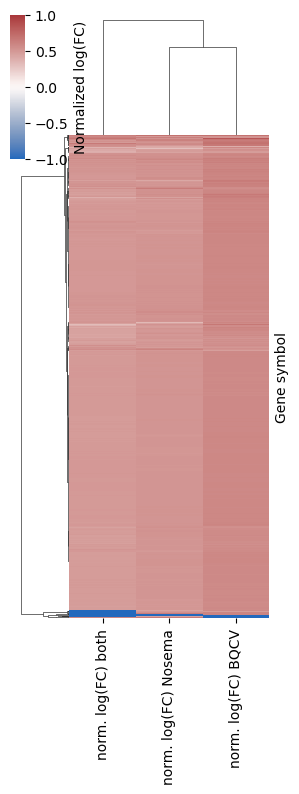

In [55]:
result = sns.clustermap(
    temp_df, 
    method='ward',
    cmap='vlag',
    figsize=(3,8),
    cbar_kws={"label":"Normalized log(FC)"},
    yticklabels=False,
    xticklabels=True,
)

The majority oof the genes are not significantlly over or uner-represented. However, there are some cluster effects. We will next focus on theh genes that have a large effect size (i.e. top or boottom 5%). We recognize that proper FDR will need to be performed in a later iteration.

## Strongly up-/down-regulated genes
At this point, we want to see whhich genes are, in fact, over or under expresse in the various experimental conditions. We are plotting the top 5% and the bottom 5% of log(FC) values calculated in the previous section.

In [ ]:
# create list of genes of interest


## Hygiene-related genes
Since our central question related to genes known to play a role in hygienic behaviors in honeybees, we want to examine the fold-change of these genes in our diseased bee dataset.

In [91]:
hyg_df.sort_values('log(FC)', ascending=False).loc[hyg_df['Hygiene']=='H', :][0:10]

Gene Hygiene Chromosome  Hygienic FPKM  Non-hygienic FPKM  \
2        CYP6AS1       H      Chr13        2.04404           0.281032   
27          Syn1       H      Chr10       23.53630           3.924320   
6   LOC100577331       H      Chr10       39.15920           8.775030   
7   LOC100578672       H       Chr4        4.01496           1.023430   
14     LOC551908       H      Chr15        2.32533           0.728909   
19     LOC724228       H       Chr5        1.43709           0.551194   
8   LOC100578804       H       Chr6        2.30117           0.888719   
5   LOC100576840       H      Chr12       23.49890           9.152220   
13     LOC412162       H       Chr7        1.65605           0.661079   
24         Myo20       H      Chr10        2.27885           0.939329   

     q_value                                Gene product        FC   log(FC)  
2   0.007550                        cytochrome P450 6AS1  7.273335  1.984215  
27  0.007550                           syntrophin-like 1  5.997549  1.791351  
6   0.028690           hypothetical protein LOC100577331  4.462572  1.495725  
7   0.007550           hypothetical protein LOC100578672  3.923043  1.366868  
14  0.007550              hypothetical protein LOC551908  3.190151  1.160068  
19  0.023908                           neprilysin-2-like  2.607231  0.958289  
8   0.007550                   hypothetical LOC100578804  2.589311  0.951392  
5   0.023908           hypothetical protein LOC100576840  2.567563  0.942957  
13  0.036737  armadillo repeat-containing protein 4-like  2.505071  0.918317  
24  0.007550                                   myosin 20  2.426040  0.886260

In [115]:
small_df = pd.DataFrame(columns=['Gene symbol', "Hygiene", "log(FC)", "log(FC) Nosema", "log(FC) BQCV", "log(FC) both"])

# pick out top 10 hygienic genes and top 10 unhygienic genes
H_genes_df = hyg_df.sort_values('log(FC)', ascending=False).loc[hyg_df['Hygiene']=='H', :][0:10]
NH_genes_df = hyg_df.sort_values('log(FC)', ascending=False).loc[hyg_df['Hygiene']=='NH', :][0:10]

# extract the gene names
H_gene_names = H_genes_df['Gene'].values
NH_gene_names = NH_genes_df['Gene'].values

# find the corresponding genes if they are present
for H_gene in H_gene_names:
    if len(avg_counts.loc[avg_counts['Gene symbol']==H_gene, :]) > 0:
        temp_dct = {
            "Gene symbol":H_gene,
            "Hygiene":H_genes_df.loc[H_genes_df['Gene']==H_gene, "Hygiene"].values[0],
            "log(FC)":H_genes_df.loc[H_genes_df['Gene']==H_gene, "log(FC)"].values[0],
            "log(FC) Nosema":avg_counts.loc[avg_counts['Gene symbol']==H_gene, "log(FC) Nosema"].values[0],
            "log(FC) BQCV":avg_counts.loc[avg_counts['Gene symbol']==H_gene, "log(FC) BQCV"].values[0],
            "log(FC) both":avg_counts.loc[avg_counts['Gene symbol']==H_gene, "log(FC) both"].values[0],
        }
        small_df = small_df.append(temp_dct, ignore_index=True)
    else:
        continue
        
# find the corresponding genes if they are present
for H_gene in NH_gene_names:
    if len(avg_counts.loc[avg_counts['Gene symbol']==H_gene, :]) > 0:
        temp_dct = {
            "Gene symbol":H_gene,
            "Hygiene":NH_genes_df.loc[NH_genes_df['Gene']==H_gene, "Hygiene"].values[0],
            "log(FC)":NH_genes_df.loc[NH_genes_df['Gene']==H_gene, "log(FC)"].values[0],
            "log(FC) Nosema":avg_counts.loc[avg_counts['Gene symbol']==H_gene, "log(FC) Nosema"].values[0],
            "log(FC) BQCV":avg_counts.loc[avg_counts['Gene symbol']==H_gene, "log(FC) BQCV"].values[0],
            "log(FC) both":avg_counts.loc[avg_counts['Gene symbol']==H_gene, "log(FC) both"].values[0],
        }
        small_df = small_df.append(temp_dct, ignore_index=True)
    else:
        continue
        
small_df

/var/folders/hs/js845njx1_l_0gpqz9kt6sq40000gn/T/ipykernel_42331/4092765680.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  small_df = small_df.append(temp_dct, ignore_index=True)
/var/folders/hs/js845njx1_l_0gpqz9kt6sq40000gn/T/ipykernel_42331/4092765680.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  small_df = small_df.append(temp_dct, ignore_index=True)
/var/folders/hs/js845njx1_l_0gpqz9kt6sq40000gn/T/ipykernel_42331/4092765680.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  small_df = small_df.append(temp_dct, ignore_index=True)
/var/folders/hs/js845njx1_l_0gpqz9kt6sq40000gn/T/ipykernel_42331/4092765680.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futur

Gene symbol Hygiene   log(FC)  log(FC) Nosema  log(FC) BQCV  log(FC) both
0        CYP6AS1       H  1.984215    1.034882e-01     -0.340302     -0.480965
1   LOC100578672       H  1.366868   -1.175509e-01     -0.399015     -0.604749
2      LOC551908       H  1.160068    2.156222e-01     -0.088355     -0.528686
3      LOC724228       H  0.958289    4.425505e-01     -0.680315     -0.289116
4   LOC100578804       H  0.951392   -4.403842e-01     -0.176257     -1.226817
5   LOC100576840       H  0.942957    9.531109e-02     -0.171336     -0.425057
6      LOC412162       H  0.918317    2.994597e-01     -0.195457      0.105259
7         Hex70c      NH  2.623860    5.465443e-01     -0.200669     -0.382991
8      LOC552229      NH  1.660776    3.028510e-01      0.021600     -0.374295
9      LOC408608      NH  1.291729    9.999995e-07     -1.609433    -13.815511
10     LOC725838      NH  1.035890    7.114968e-01      0.488353      0.105361
11     LOC724239      NH  1.020025    2.014333e+00      0.505685      1.121845

In [197]:

genes = list(small_df['Gene symbol'].values)
years = ['Nosema', 'BQVC', 'both']

data = {'genes' : genes,
        'Nosema'   : list(small_df['log(FC) Nosema'].values),
        'BQCV'   : list(small_df['log(FC) BQCV'].values),
        'both'   : list(small_df['log(FC) both'].values)}

source = bokeh.models.ColumnDataSource(data=data)

p = bokeh.plotting.figure(
    x_range=genes, 
    # y_range=(-10, 10), 
    height=400, 
    title="Fold-change of hygiene-related genes in infected bees",
    # toolbar_location=None, 
    # tools=""
)

p.vbar(x=bokeh.transform.dodge('genes',  -0.25,  range=p.x_range), top='Nosema', width=0.2, source=source,
       color=colors[3], legend_label="Nosema")

p.vbar(x=bokeh.transform.dodge('genes',  0.0,  range=p.x_range), top='BQCV', width=0.2, source=source,
       color=colors[6], legend_label="BQCV")

p.vbar(x=bokeh.transform.dodge('genes',  0.25, range=p.x_range), top='both', width=0.2, source=source,
       color=colors[9], legend_label="both")

p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = math.pi/2
p.xgrid.grid_line_color = None
p.legend.location = "bottom_left"
p.legend.orientation = "horizontal"

bokeh.io.show(p)
